In [3]:
import scanpy as sc 
import pandas as pd 
import numpy as np 

/ihome/djishnu/alw399/.local/lib/python3.9/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [4]:
ko_adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymphKO4_visiumHD.h5ad')
ko_adata

AnnData object with n_obs × n_vars = 92969 × 2116
    obs: 'cell_type', 'secondary_annot', 'cell_type_int'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_features', 'spatial_maps', 'spatial_unscaled'
    layers: 'corrected_count', 'imputed_count', 'normalized_count', 'raw_count'

In [5]:
# gex_df = ko_adata[:, ['Prdm1', 'Ccr4']].to_df(layer='raw_count')
gex_df = ko_adata[:, ['Ccr4']].to_df(layer='raw_count')
ccr4neg = gex_df[(gex_df['Ccr4'] < 1)].index

ccr4neg_th2 = ko_adata[
        (ko_adata.obs.index.isin(ccr4neg)) 
        # & ((ko_adata.obs.cell_type == 'Th2') | (ko_adata.obs.cell_type == 'Tfh') | (ko_adata.obs.cell_type == 'Treg'))
        & ((ko_adata.obs.cell_type == 'Th2') | (ko_adata.obs.cell_type == 'Tfh'))
        # & (ko_adata.obs.cell_type == 'Th2')
        # & (ko_adata.obs.cell_type == 'Tfh')
    ].obs_names

len(ccr4neg_th2)

1014

In [17]:
ccr4pos_th2 = ko_adata[
        (~ko_adata.obs.index.isin(ccr4neg)) 
        & (ko_adata.obs.cell_type == 'Th2')
        # & ((ko_adata.obs.cell_type == 'Th2') | (ko_adata.obs.cell_type == 'Tfh'))
    ].obs_names
len(ccr4pos_th2)

22

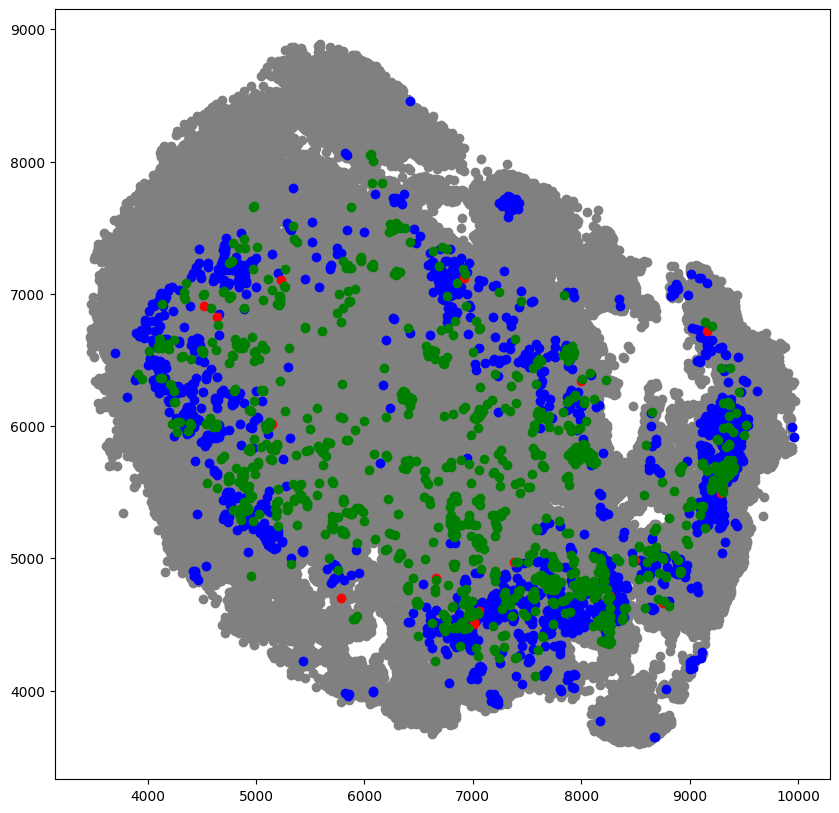

In [18]:
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(
    ko_adata.obsm['spatial'][:, 0], 
    ko_adata.obsm['spatial'][:, 1],
    color='gray'
)
plt.scatter(
    ko_adata[ko_adata.obs.cell_type == 'DC'].obsm['spatial'][:, 0],
    ko_adata[ko_adata.obs.cell_type == 'DC'].obsm['spatial'][:, 1],
    color='blue')
plt.scatter(
    ko_adata[ccr4pos_th2].obsm['spatial'][:, 0],
    ko_adata[ccr4pos_th2].obsm['spatial'][:, 1],
    color='red'
)
plt.scatter(
    ko_adata[ccr4neg_th2].obsm['spatial'][:, 0],
    ko_adata[ccr4neg_th2].obsm['spatial'][:, 1],
    color='green'
)

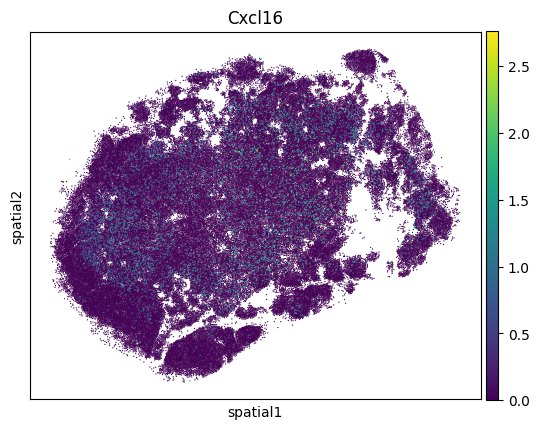

In [20]:
sc.pl.spatial(ko_adata, color=['Cxcl16'], spot_size=20, 
              layer='normalized_count', cmap='viridis')

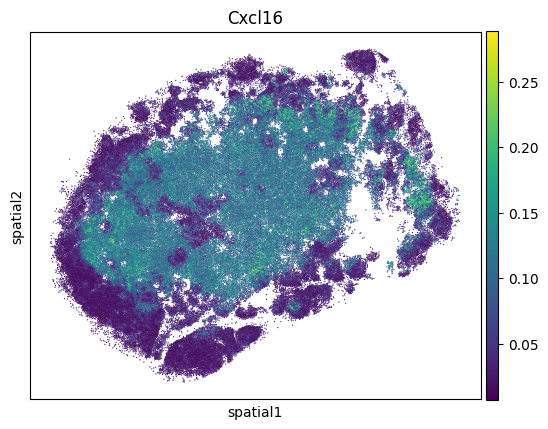

In [19]:
sc.pl.spatial(ko_adata, color=['Cxcl16'], spot_size=20, 
              layer='imputed_count', cmap='viridis')

In [7]:
rna_df = ko_adata.to_df(layer='normalized_count')
rna_df = rna_df.loc[list(ccr4neg_th2) + list(ccr4pos_th2)]
y_df = pd.DataFrame([0] * len(ccr4neg_th2) + [1] * len(ccr4pos_th2), index=rna_df.index, columns=['y'])

In [8]:
th2_adata = sc.AnnData(X=rna_df,obs=y_df, var=pd.DataFrame(index=rna_df.columns))
th2_adata.obs['y'] = th2_adata.obs['y'].astype(str).astype('category')
th2_adata

AnnData object with n_obs × n_vars = 1079 × 2116
    obs: 'y'

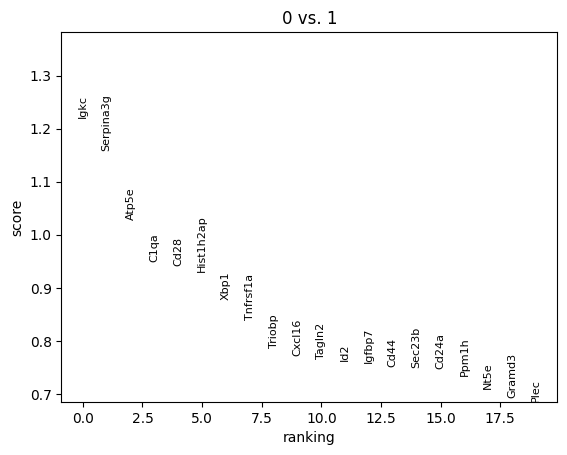

In [9]:
sc.tl.rank_genes_groups(th2_adata, groupby='y', method='wilcoxon', reference='1')
sc.pl.rank_genes_groups(th2_adata, n_genes=20, group='0')

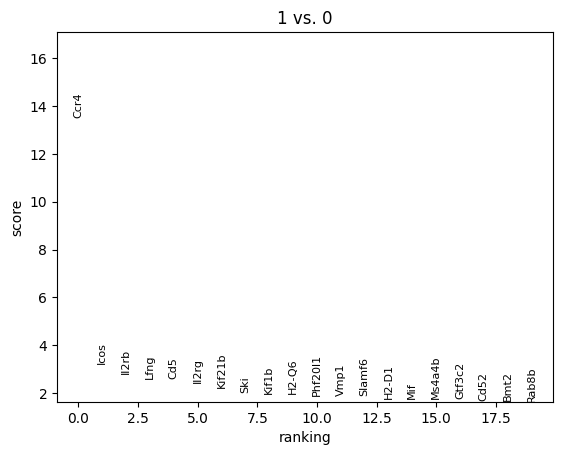

In [10]:
th2_adata.obs['y'] = th2_adata.obs['y'].astype(str).astype('category')
sc.tl.rank_genes_groups(th2_adata, groupby='y', method='wilcoxon', reference='0')
sc.pl.rank_genes_groups(th2_adata, n_genes=20, group='1')
degs = sc.get.rank_genes_groups_df(th2_adata, group='1')


In [11]:
degs.head(20).names.values

array(['Ccr4', 'Icos', 'Il2rb', 'Lfng', 'Cd5', 'Il2rg', 'Kif21b', 'Ski',
       'Kif1b', 'H2-Q6', 'Phf20l1', 'Vmp1', 'Slamf6', 'H2-D1', 'Mif',
       'Ms4a4b', 'Gtf3c2', 'Cd52', 'Bmt2', 'Rab8b'], dtype=object)

In [42]:
degs.sort_values(by='pvals_adj')

names     scores  logfoldchanges         pvals     pvals_adj
0          Ccr4  13.530829       30.067032  1.028571e-41  2.176457e-38
2105     Tagln2  -0.765946       -0.481161  4.437082e-01  1.000000e+00
2106     Cxcl16  -0.772105       -2.471706  4.400522e-01  1.000000e+00
2107     Triobp  -0.787297      -25.659796  4.311082e-01  1.000000e+00
2108   Tnfrsf1a  -0.840673      -25.600470  4.005313e-01  1.000000e+00
...         ...        ...             ...           ...           ...
39        Ncoa7   1.412207        1.042376  1.578890e-01  1.000000e+00
40        Fnbp4   1.373202        1.363372  1.696897e-01  1.000000e+00
2114  Serpina3g  -1.157439       -1.239969  2.470930e-01  1.000000e+00
2115       Igkc  -1.221285       -0.583220  2.219781e-01  1.000000e+00
1          Icos   3.207285        1.070222  1.339943e-03  1.000000e+00

[2116 rows x 5 columns]

In [27]:
degs[degs.names.isin(['Lck', 'Ighm', 'Igkc'])]

names    scores  logfoldchanges     pvals  pvals_adj
106    Lck  0.866598        0.343065  0.386162        1.0
2108  Ighm -0.924065       -0.557033  0.355453        1.0
2115  Igkc -1.902148       -1.073368  0.057152        1.0

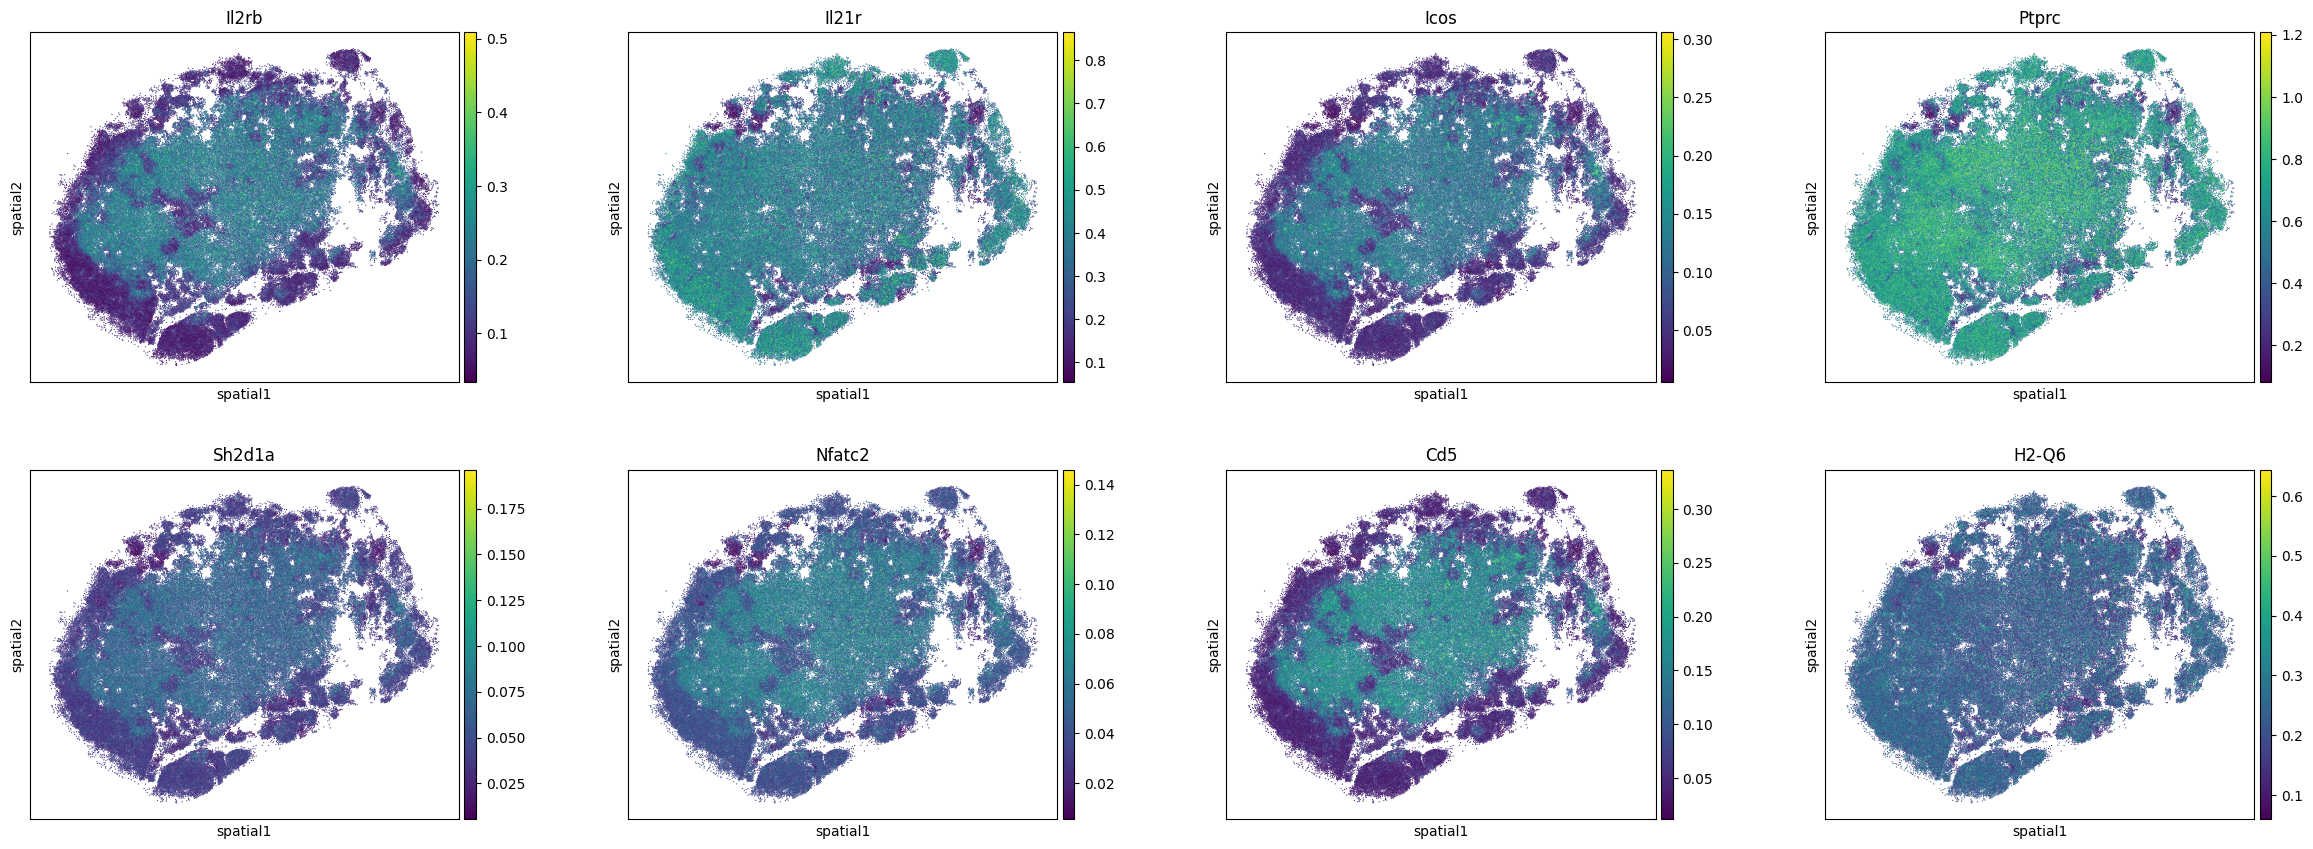

In [9]:
sc.pl.spatial(ko_adata, color=['Il2rb', 'Il21r', 'Icos', 'Ptprc', 'Sh2d1a', 'Nfatc2', 'Cd5', 'H2-Q6'], spot_size=20, 
              layer='imputed_count', cmap='viridis')

In [ ]:
import commot as ct 
import sys 
sys.path.append('../../src')
from spaceoracle.tools.network import expand_paired_interactions

df_ligrec = ct.pp.ligand_receptor_database(
    database='CellChat', 
    species='mouse', 
    signaling_type=None
) 
df_ligrec.columns = ['ligand', 'receptor', 'pathway', 'signaling']  

lr = expand_paired_interactions(df_ligrec)
lr = lr[lr.ligand.isin(ko_adata.var_names) &\
    (lr.receptor.isin(ko_adata.var_names))]

lr.head(3)

2025-07-11 17:28:35.807216: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /ihome/crc/install/gcc-12.2.0/postgresql/15.2/lib:/ihome/crc/install/gcc-12.2.0/imagemagick/6.9.12/lib:/ihome/crc/install/gcc-12.2.0/geos/3.9.4/lib:/ihome/crc/install/gcc-12.2.0/zstd/zstd-1.5.5/lib:/ihome/crc/install/gcc-12.2.0/unixodbc/2.3.11/lib:/ihome/crc/install/sodium/1.0.18/lib:/ihome/crc/install/gcc-12.2.0/r/4.4.0/lib64/R/lib:/ihome/crc/install/gcc-12.2.0/openmpi/4.1.5/lib:/ihome/crc/install/gcc-12.2.0/fftw/3.3.10/lib:/ihome/crc/install/gcc-12.2.0/glpk/5.0/lib:/ihome/crc/install/gcc-12.2.0/proj/4.9.3/lib:/ihome/crc/install/gcc-12.2.0/gdal/2.4.4/lib:/ihome/crc/install/gcc-12.2.0/netcdf/4.8.1/lib:/ihome/crc/install/gcc-12.2.0/hdf5/1.14.0/lib:/ihome/crc/install/gcc-12.2.0/jags/4.3.2/lib:/ihome/crc/install/gcc-12.2.0/gsl/2.7.1/lib:/ihome/c

In [1]:
lr[lr.ligand == 'Cxcl16']

NameError: name 'lr' is not defined

In [11]:
lr[lr.receptor == 'Ccr4']

ligand receptor pathway           signaling
645  Ccl17     Ccr4     CCL  Secreted Signaling
646  Ccl22     Ccr4     CCL  Secreted Signaling
647   Ccl5     Ccr4     CCL  Secreted Signaling

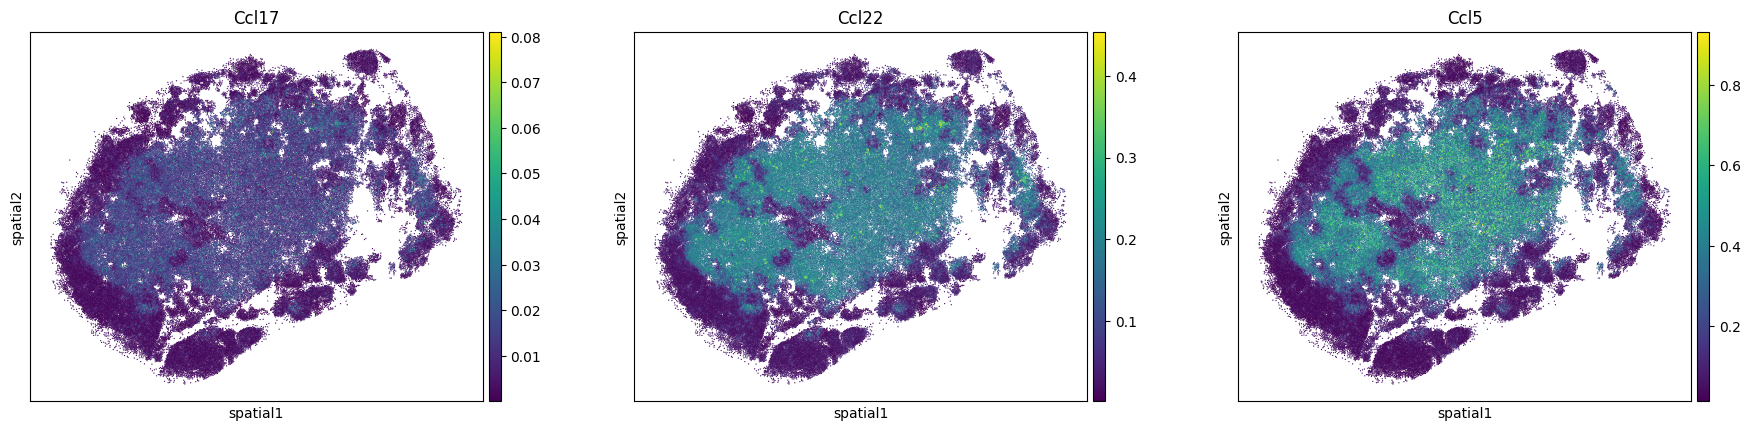

In [12]:
sc.pl.spatial(ko_adata, color=['Ccl17', 'Ccl22', 'Ccl5'], spot_size=20, 
              layer='imputed_count', cmap='viridis')

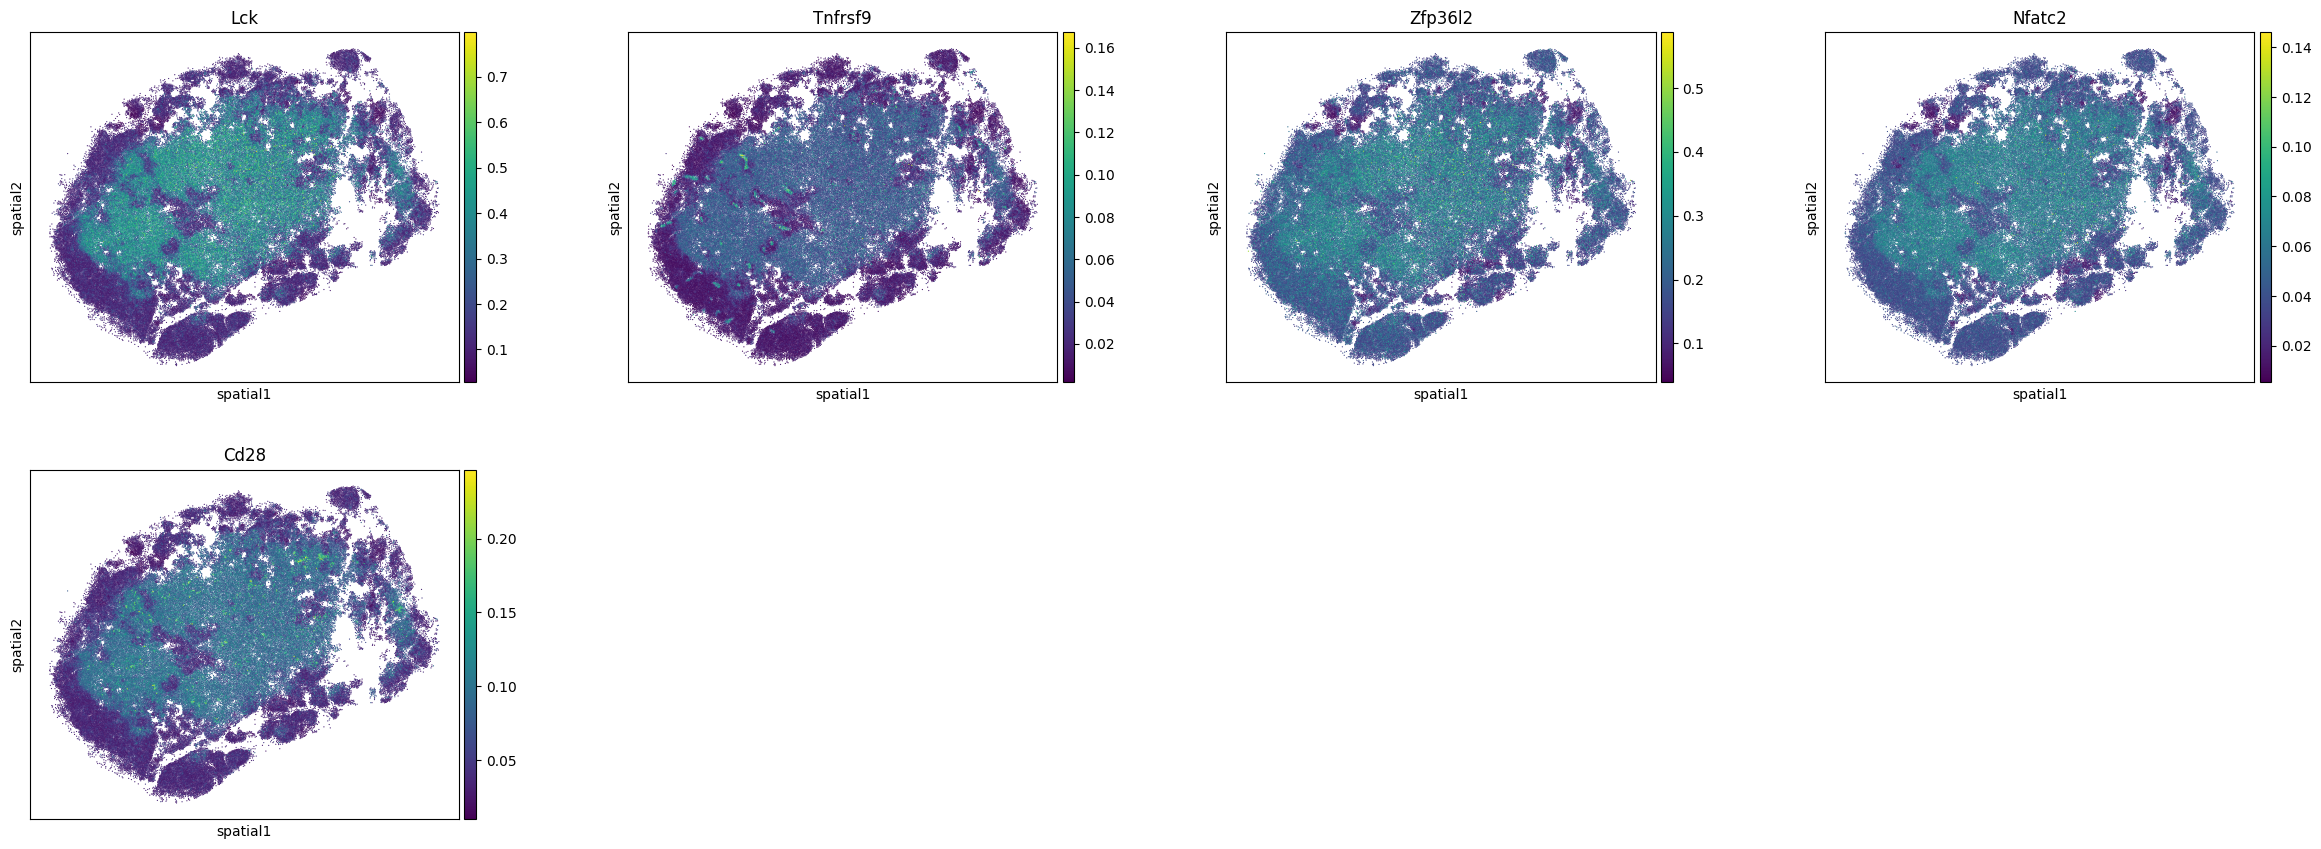

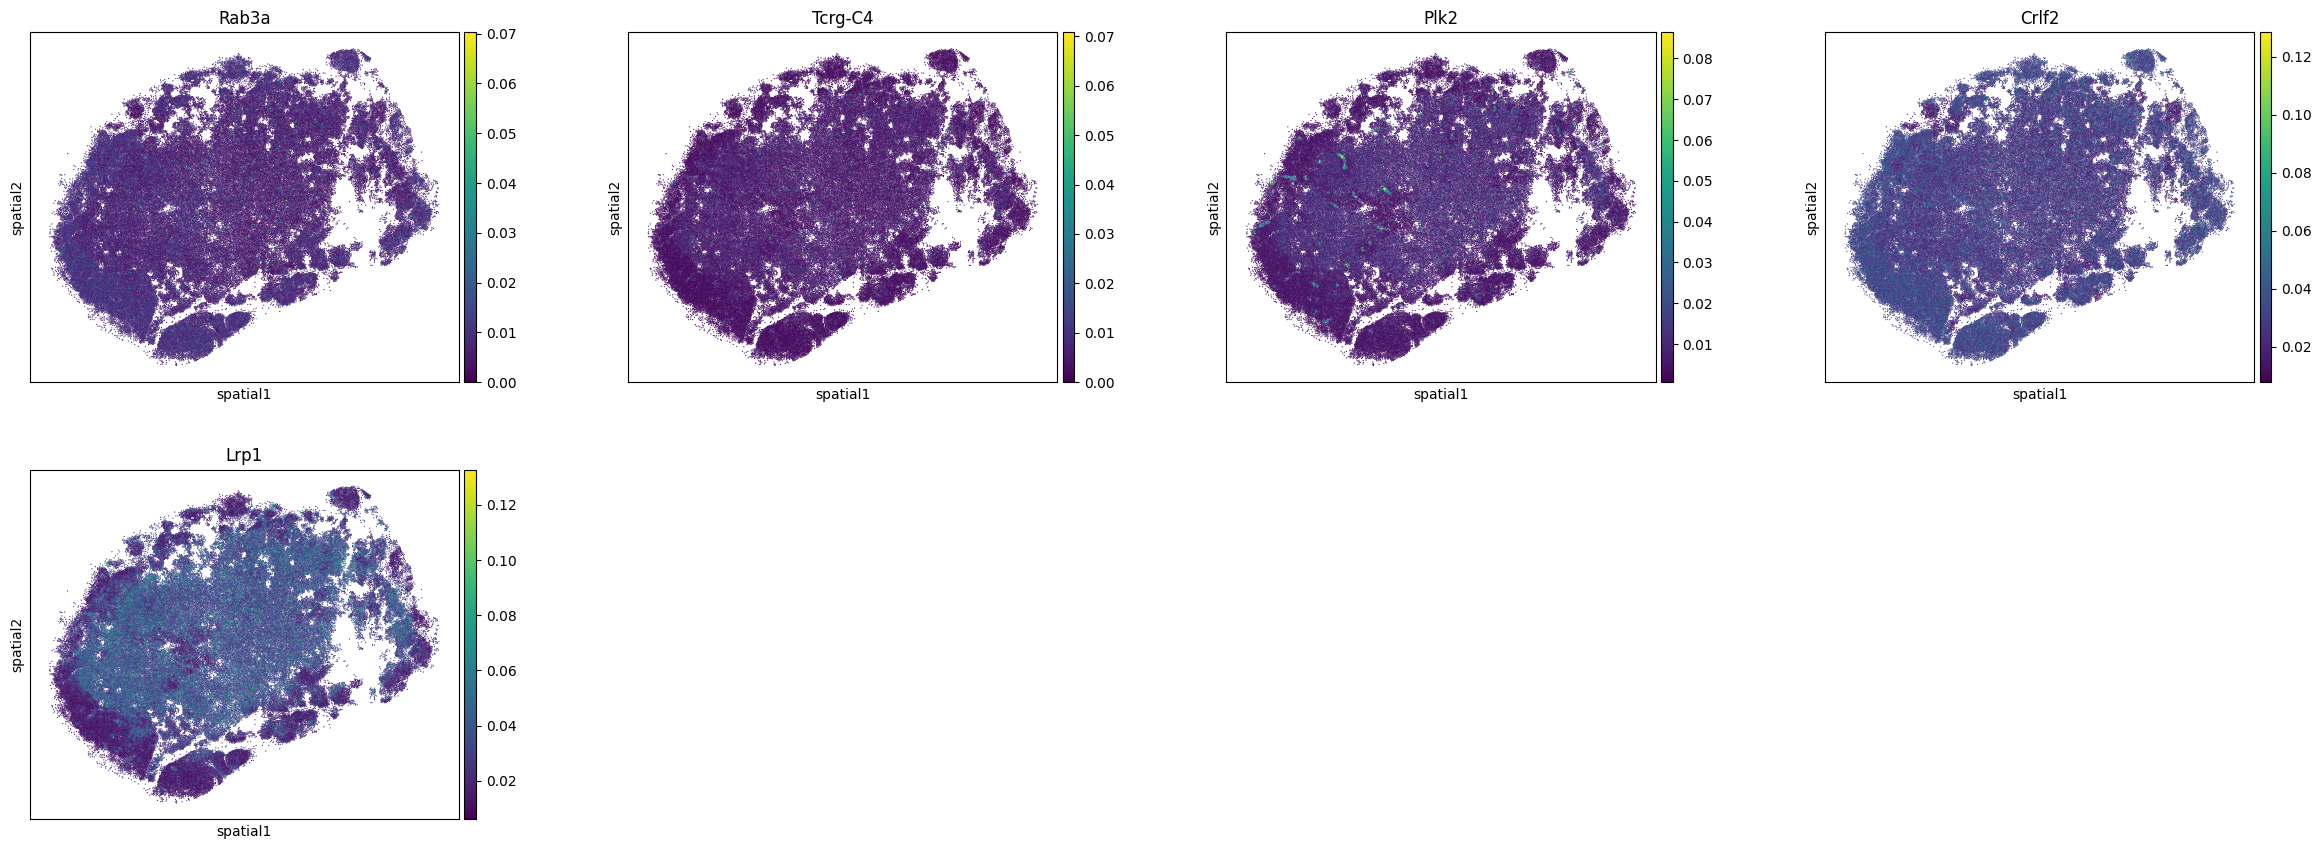

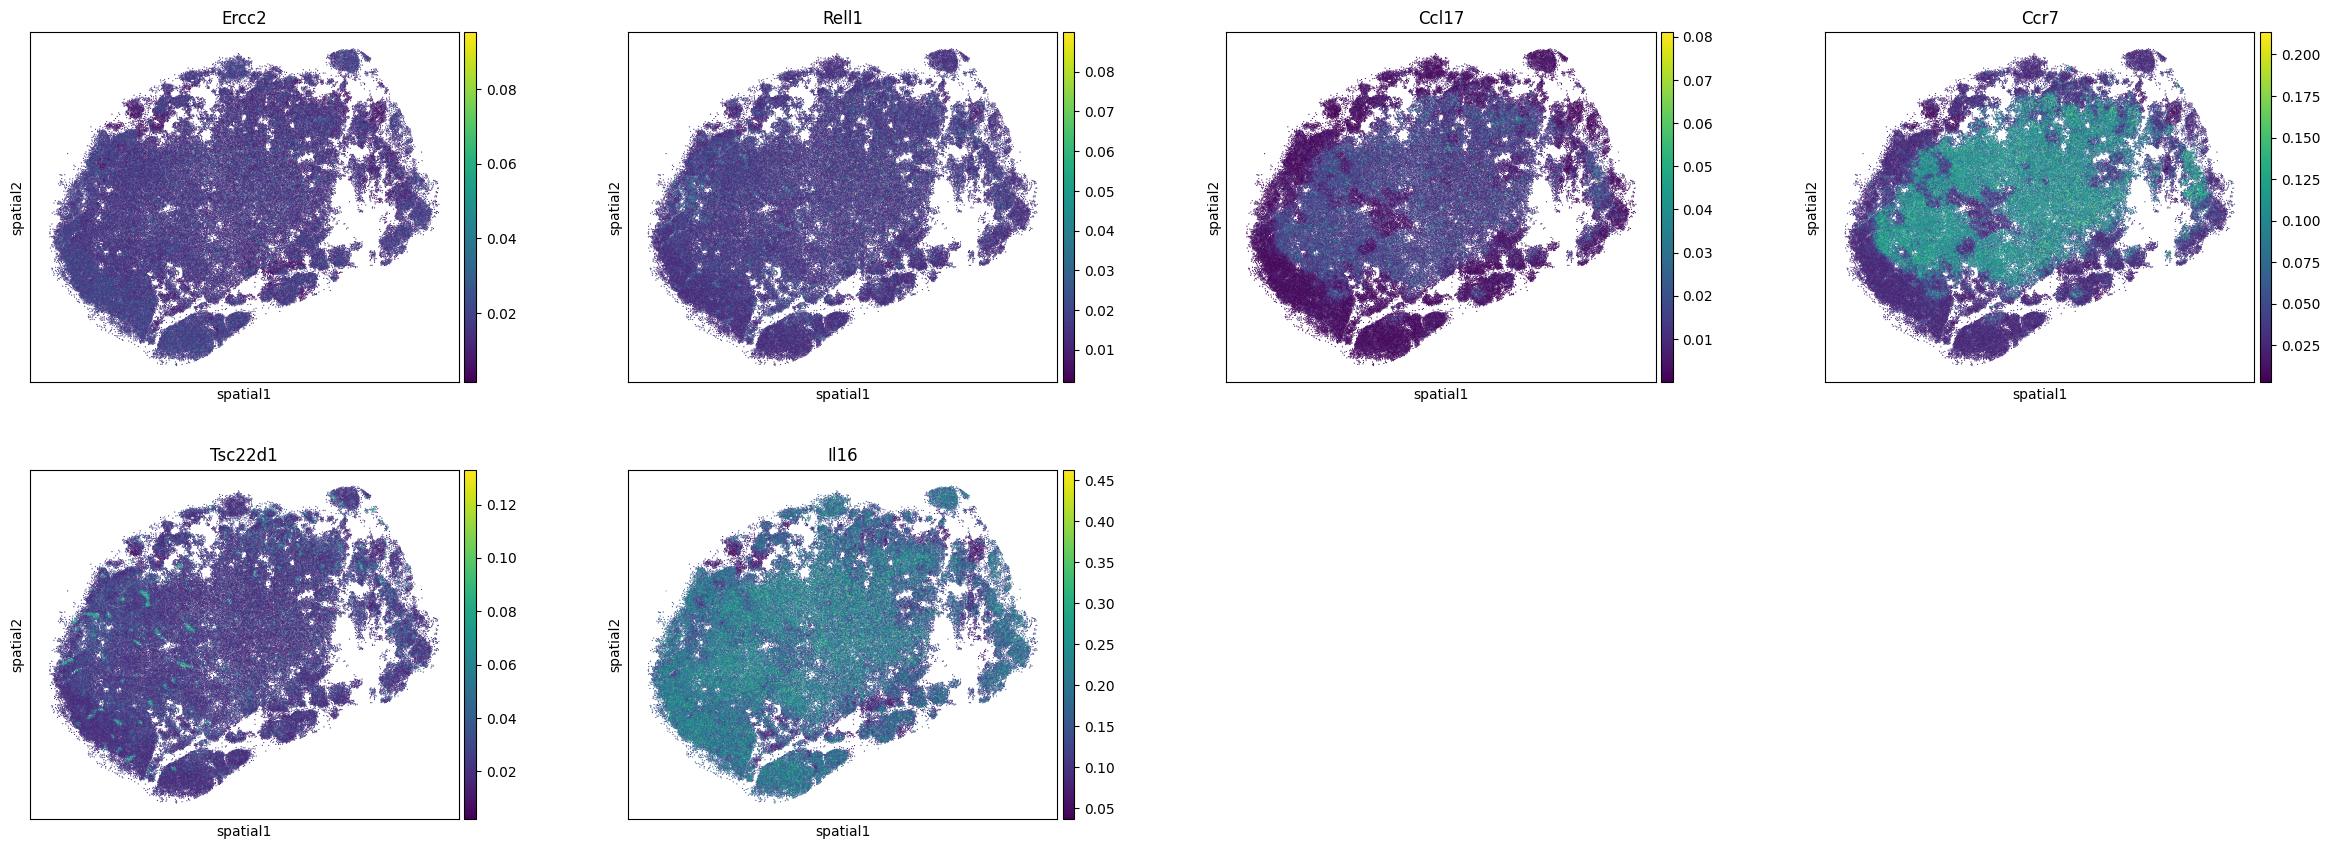

In [13]:
sc.pl.spatial(ko_adata, color=['Lck', 'Tnfrsf9', 'Zfp36l2', 'Nfatc2', 'Cd28'], spot_size=20, layer='imputed_count', cmap='viridis')
sc.pl.spatial(ko_adata, color=['Rab3a', 'Tcrg-C4', 'Plk2', 'Crlf2', 'Lrp1'], spot_size=20, layer='imputed_count', cmap='viridis')
sc.pl.spatial(ko_adata, color=['Ercc2', 'Rell1', 'Ccl17', 'Ccr7', 'Tsc22d1', 'Il16'], spot_size=20, layer='imputed_count', cmap='viridis')

In [14]:
from spaceoracle.beta import Betabase
from pathlib import Path

parts = ['a', 'b']
lasso_dir = Path('/ix/djishnu/shared/djishnu_kor11/lasso_runs')
lasso_dirs = [lasso_dir / f'mouse_lymphKO{part}_visiumHD' for part in parts]
adatas = {
    part: sc.read_h5ad(f'/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymphKO4{part}_visiumHD.h5ad')
    for part in parts
}

In [15]:
bdbs = {
    part: Betabase(
        adatas[part],
        lasso_dir / f'mouse_lymphKO4{part}_visiumHD',
        subsample=None,
        float16=True,
    )
    for part in parts
}


In [16]:
bdb_data = {
    target: pd.concat([bdbs[part].data.get(target, pd.DataFrame()) for part in parts], axis=0)
    for target in bdbs['a'].data.keys()
}
bdb_data.keys()

dict_keys(['Msrb1', 'Mrc1', 'Dll4', 'Gzmm', 'Lman2l', 'Synpo2', 'Fbxl5', 'Klrc1', 'Tdgf1', 'Pde4b', 'Scn1b', 'Naaa', 'Tnfsf8', 'Zmym1', 'Pde2a', 'G0s2', 'Ifi207', 'Il18', 'Parp14', 'Dclre1a', 'Xrn1', 'Wsb2', 'Plekhm2', 'Aldh1a2', 'Notch2', 'Dnph1', 'Cycs', 'Slc8b1', 'Cyb5r1', 'Slc11a2', 'D16Ertd472e', 'Xpnpep1', 'Mkrn1', 'Ica1l', 'Pdlim4', 'Ercc6', 'Daam1', 'Marcksl1', 'Tulp4', 'Wtip', 'Zfp281', 'Ing4', 'Btla', 'Sapcd1', 'Unc5cl', 'Fam89a', 'Cryba4', 'Ctsb', 'Nfe2l2', 'Kctd18', 'Capns1', 'Fads2', 'Zfp329', 'Etaa1', 'Brat1', 'Myb', 'Tapbpl', 'Rbak', 'Gtf3c4', 'Egr1', 'Cmtm4', 'Atn1', 'Ubash3a', 'Gtsf1', 'Chst2', 'Zcchc17', 'Izumo1r', 'Arl5a', 'Clk2', 'Kcne3', 'Nampt', 'Tmem71', 'Dna2', 'Rufy2', 'Map1s', 'Dapl1', 'Paxbp1', 'Tmem184b', 'Diaph3', 'Spata6', 'Gramd1a', 'F2rl1', 'Ubald1', 'Rbm44', 'Poli', 'Tmie', 'Pknox1', 'Cp', 'Slc2a1', 'Tmem250-ps', 'Lyz2', 'Scand1', 'Cpm', 'Dvl2', 'Idh2', 'Dlg4', 'Uqcrh', 'Cd274', 'Ccdc122', 'Slc30a2', 'Neurl3', 'Prlr', 'Tmem158', 'Nupr1', 'Gmeb1', 'Pgam2

In [17]:
from tqdm import tqdm
import networkx as nx

ccr4neg_th2_edges = []
ccr4pos_th2_edges = []

for target_gene, mod_df in tqdm(bdb_data.items()):
    neg_cells = [x for x in ccr4neg_th2 if x in mod_df.index]
    if 'beta0' in mod_df.columns:
        mod_df = mod_df.drop('beta0', axis=1)
    mod_dict_neg = (
        mod_df.loc[neg_cells]
        .mean(axis=0)
        .to_dict()
    )
    flattened_neg = {}
    for mod, effect in mod_dict_neg.items():
        if '$' in mod:
            flattened_neg[mod.split('$')[-1]] = effect
        elif '#' in mod:
            for part in mod.split('#'):
                flattened_neg[part] = effect
        else:
            flattened_neg[mod] = effect

    ccr4neg_th2_edges.extend([
        [modulator.replace('beta_', ''), target_gene, effect]
        for modulator, effect in flattened_neg.items()
    ])

    pos_cells = [x for x in ccr4pos_th2 if x in mod_df.index]
    if 'beta0' in mod_df.columns:
        mod_df = mod_df.drop('beta0', axis=1)
    mod_dict_pos = (
        mod_df.loc[pos_cells]
        .mean(axis=0)
        .to_dict()
    )
    flattened_pos = {}
    for mod, effect in mod_dict_pos.items():
        if '$' in mod:
            flattened_pos[mod.split('$')[-1]] = effect
        elif '#' in mod:
            for part in mod.split('#'):
                flattened_pos[part] = effect
        else:
            flattened_pos[mod] = effect

    ccr4pos_th2_edges.extend([
        [modulator.replace('beta_', ''), target_gene, effect]
        for modulator, effect in flattened_pos.items()
    ])

In [18]:
pos_grn = nx.DiGraph()
neg_grn = nx.DiGraph()

pos_grn.add_nodes_from(ko_adata.var_names)
neg_grn.add_nodes_from(ko_adata.var_names)

pos_edges = [
    [source, target, round(100 * effect)]
    for source, target, effect in ccr4pos_th2_edges
]
neg_edges = [
    [source, target, round(100 * effect)]
    for source, target, effect in ccr4neg_th2_edges
]

# Add edges to graphs
pos_grn.add_weighted_edges_from(pos_edges)
neg_grn.add_weighted_edges_from(neg_edges)


In [19]:
def compare_pos_neg(modulator, target, n_hops=3):
    pos_effect = 0
    for path in nx.all_simple_paths(pos_grn, source=modulator, target=target, cutoff=n_hops):
        weights = [pos_grn[u][v]['weight'] for u, v in zip(path, path[1:])]
        pos_effect += np.prod(weights)

    neg_effect = 0
    for path in nx.all_simple_paths(neg_grn, source=modulator, target=target, cutoff=n_hops):
        weights = [neg_grn[u][v]['weight'] for u, v in zip(path, path[1:])]
        neg_effect += np.prod(weights)

    print(f'{modulator} → {target}')
    print(f"Ccr4+Th2: {pos_effect}")
    print(f"Ccr4-Th2: {neg_effect}\n")
    

In [29]:
compare_pos_neg('Ccr4', 'Ercc2') 
compare_pos_neg('Ccr4', 'Rell1') 
compare_pos_neg('Ccr4', 'Tcrg-C4') 
compare_pos_neg('Ccr4', 'Crlf2') 
compare_pos_neg('Ccr4', 'Rab3a') 
compare_pos_neg('Ccr4', 'Il16') 
compare_pos_neg('Ccr4', 'Plk2') 
compare_pos_neg('Ccr4', 'Lrp1') 

Ccr4 → Ercc2
Ccr4+Th2: 67
Ccr4-Th2: 80

Ccr4 → Rell1
Ccr4+Th2: 202
Ccr4-Th2: 173

Ccr4 → Tcrg-C4
Ccr4+Th2: 0
Ccr4-Th2: 0

Ccr4 → Crlf2
Ccr4+Th2: 66
Ccr4-Th2: 20

Ccr4 → Rab3a
Ccr4+Th2: 1
Ccr4-Th2: -5

Ccr4 → Il16
Ccr4+Th2: 185
Ccr4-Th2: 292

Ccr4 → Plk2
Ccr4+Th2: -69
Ccr4-Th2: -45

Ccr4 → Lrp1
Ccr4+Th2: -15
Ccr4-Th2: 14



In [20]:
compare_pos_neg('Ccr4', 'Il2rb') 
compare_pos_neg('Ccr4', 'Il21r')
compare_pos_neg('Ccr4', 'Icos')
compare_pos_neg('Ccr4', 'Ptprc')
compare_pos_neg('Ccr4', 'Sh2d1a')
compare_pos_neg('Ccr4', 'Nfatc2')
compare_pos_neg('Ccr4', 'Cd5')
compare_pos_neg('Ccr4', 'H2-Q6')

Ccr4 → Il2rb
Ccr4+Th2: -45
Ccr4-Th2: 197



Ccr4 → Il21r
Ccr4+Th2: 195
Ccr4-Th2: -12

Ccr4 → Icos
Ccr4+Th2: 131
Ccr4-Th2: 105

Ccr4 → Ptprc
Ccr4+Th2: 2676
Ccr4-Th2: 2786

Ccr4 → Sh2d1a
Ccr4+Th2: 19
Ccr4-Th2: -10

Ccr4 → Nfatc2
Ccr4+Th2: 453
Ccr4-Th2: 397

Ccr4 → Cd5
Ccr4+Th2: 1199
Ccr4-Th2: 879

Ccr4 → H2-Q6
Ccr4+Th2: 0
Ccr4-Th2: 0



In [21]:
compare_pos_neg('Ccr4', 'Lck') 
compare_pos_neg('Ccr4', 'Tnfrsf9')
compare_pos_neg('Ccr4', 'Zfp36l2')

compare_pos_neg('Ccr4', 'Ccl17')
compare_pos_neg('Ccr4', 'Ccl22')
compare_pos_neg('Ccr4', 'Ccl5')

Ccr4 → Lck
Ccr4+Th2: 951
Ccr4-Th2: 794

Ccr4 → Tnfrsf9
Ccr4+Th2: 33
Ccr4-Th2: 62

Ccr4 → Zfp36l2
Ccr4+Th2: 267
Ccr4-Th2: 377

Ccr4 → Ccl17
Ccr4+Th2: 1
Ccr4-Th2: 2

Ccr4 → Ccl22
Ccr4+Th2: 461
Ccr4-Th2: 513

Ccr4 → Ccl5
Ccr4+Th2: -6
Ccr4-Th2: 8



### Run SLIDE

In [ ]:
# import sys 
# sys.path.append('/ix3/djishnu/alw399/SLIDE_PLM/src')
# from SLIDE_py.SLIDE.slide import OptimizeSLIDE

In [7]:
# slide_gex_params = {
#     'fdr' : 0.1,
#     'thresh_fdr': 0.1,
#     'spec' : 0.2,
#     'y_factor': True,
#     'niter' : 500,
#     'SLIDE_top_feats': 20,
#     'pure_homo' : True,
#     'delta' : [0.1, 0.01],
#     'lambda' : [0.5, 0.1, 1, 2],
#     'out_path': 'slide_outs/ko_ccr4posneg',
#     'log_transform': False,
#     'use_all_vars': False,
#     'do_interacts': True
# }

# slide_gex = OptimizeSLIDE(
#     slide_gex_params, 
#     x=rna_df, 
#     y=y_df
# )

In [7]:
# slide_gex.run_pipeline(verbose=True, rerun=False)